# Importing Libraries and Defining Constants

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import os

# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
n_classes = 3


# Loading Dataset

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)


Found 1565 files belonging to 2 classes.
['Strawberry___Leaf_scorch', 'Strawberry___healthy']


# Plotting Sample Images

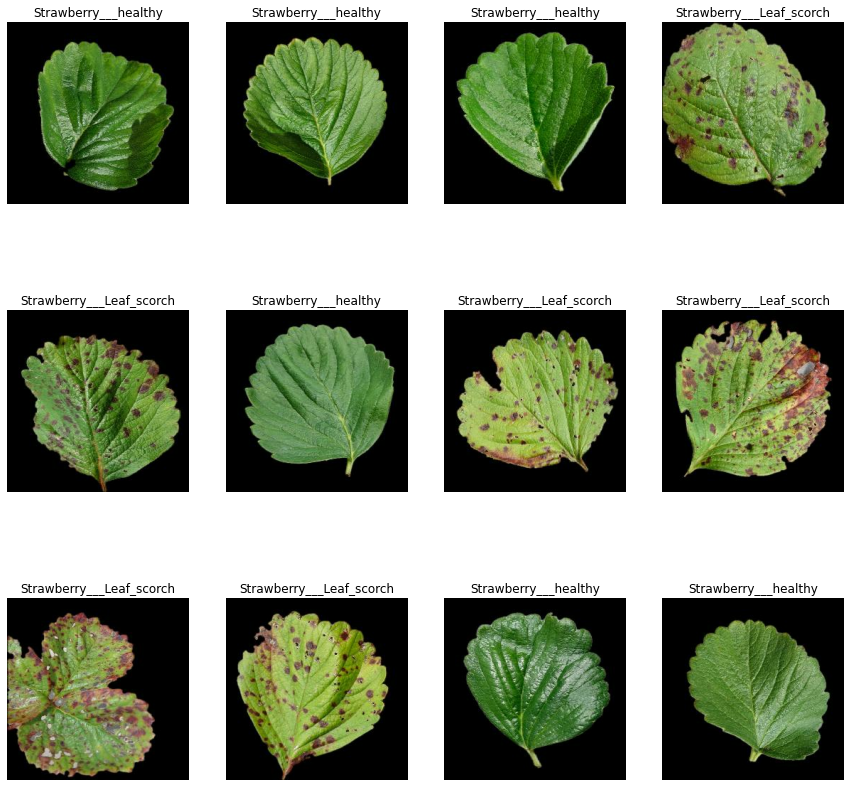

In [3]:
def plot_sample_images(dataset):
    plt.figure(figsize=(15, 15))
    for image_batch, label_batch in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")
    plt.show()

plot_sample_images(dataset)


# Partitioning Dataset

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")


Train dataset size: 39
Validation dataset size: 4
Test dataset size: 6


# Defining Model Creation Function and Utility Functions

In [5]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

def create_model(input_shape, n_classes, activations):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation=activations[0]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activations[1]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activations[2]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activations[3]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activations[4]),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activations[5]),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation=activations[6]),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

def plot_predictions(model, test_ds):
    plt.figure(figsize=(15, 15))
    for images, labels in test_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]]
            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
            plt.axis("off")
    plt.show()

def predict_and_evaluate(model, test_ds):
    y_true = []
    y_pred = []
    for images_batch, labels_batch in test_ds:
        batch_prediction = model.predict(images_batch)
        y_true.extend(labels_batch.numpy())
        y_pred.extend(np.argmax(batch_prediction, axis=1))
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    loss, accuracy = model.evaluate(test_ds)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Loss: {loss:.4f}')
    plot_predictions(model, test_ds)
    return precision, recall, f1, accuracy, loss


# Training and Evaluating Models with Different Activation Functions

Training model with activations: ['relu', 'sigmoid', 'tanh', 'relu', 'sigmoid', 'tanh', 'relu']
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 511ms/step - accuracy: 0.5849 - loss: 0.7569 - val_accuracy: 0.7422 - val_loss: 0.5754
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.7040 - loss: 0.6141 - val_accuracy: 0.7422 - val_loss: 0.5747
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.6916 - loss: 0.6276 - val_accuracy: 0.7422 - val_loss: 0.5834
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.7103 - loss: 0.6055 - val_accuracy: 0.7422 - val_loss: 0.5539
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 511ms/step - accuracy: 0.7728 - loss: 0.4557 - val_accuracy: 0.8047 - val_loss: 0.4549
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 524ms/step - accuracy: 0.8745 - loss: 0.3212 - val_accuracy: 0.8594 - val_loss: 0.2796
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 548ms/step - accuracy: 0.8802 - loss: 0.2767 - val_accuracy: 0.9219 - val_loss: 0.1947
E

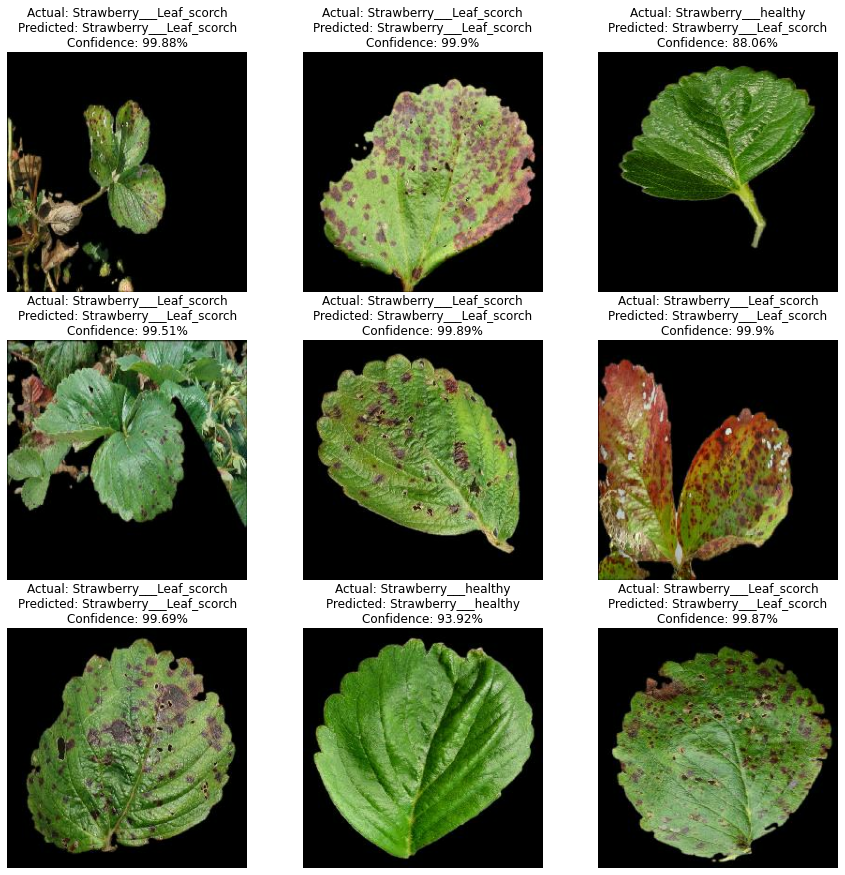

Training model with activations: ['tanh', 'relu', 'selu', 'sigmoid', 'tanh', 'relu', 'selu']
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 606ms/step - accuracy: 0.6407 - loss: 0.8169 - val_accuracy: 0.7422 - val_loss: 0.5635
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 583ms/step - accuracy: 0.8139 - loss: 0.4113 - val_accuracy: 0.8828 - val_loss: 0.2895
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - accuracy: 0.9486 - loss: 0.1358 - val_accuracy: 0.9219 - val_loss: 0.1888
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 625ms/step - accuracy: 0.9373 - loss: 0.1435 - val_accuracy: 0.9766 - val_loss: 0.0453
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 595ms/step - accuracy: 0.9330 - loss: 0.1488 - val_accuracy: 0.9922 - val_loss: 0.0384
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 598ms/step - accuracy: 0.9836 - loss: 0.0423 - val_accuracy: 0.9844 - val_loss: 0.0202
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 586ms/step - accuracy: 0.9843 - loss: 0.0406 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoc

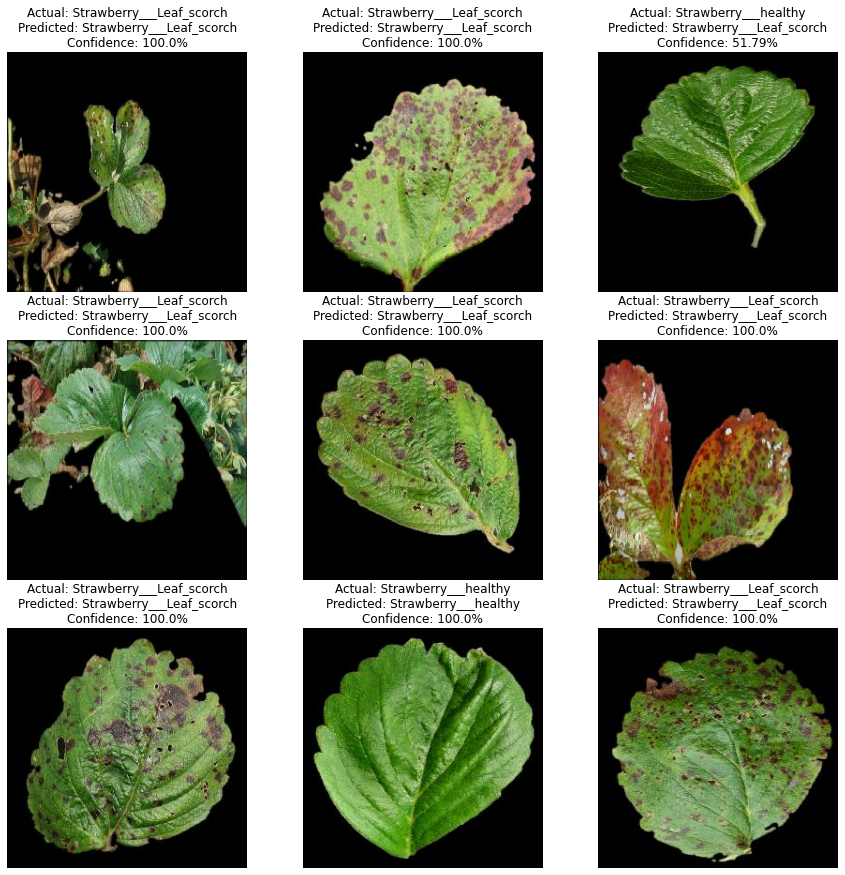

Training model with activations: ['sigmoid', 'selu', 'relu', 'tanh', 'sigmoid', 'selu', 'tanh']
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 638ms/step - accuracy: 0.6328 - loss: 0.7390 - val_accuracy: 0.7422 - val_loss: 0.5710
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 572ms/step - accuracy: 0.7150 - loss: 0.6025 - val_accuracy: 0.7422 - val_loss: 0.5829
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 589ms/step - accuracy: 0.7164 - loss: 0.6023 - val_accuracy: 0.7422 - val_loss: 0.5754
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 580ms/step - accuracy: 0.7081 - loss: 0.6062 - val_accuracy: 0.7422 - val_loss: 0.5710
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 553ms/step - accuracy: 0.7061 - loss: 0.6104 - val_accuracy: 0.7422 - val_loss: 0.5739
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - accuracy: 0.7082 - loss: 0.6081 - val_accuracy: 0.7422 - val_loss: 0.5709
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - accuracy: 0.7131 - loss: 0.6008 - val_accuracy: 0.7422 - val_loss: 0.5709
E

D:\Users\RITUJA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.7441 - loss: 0.5783
Precision: 0.5703
Recall: 0.7552
F1 Score: 0.6499
Accuracy: 0.7552
Loss: 0.5699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


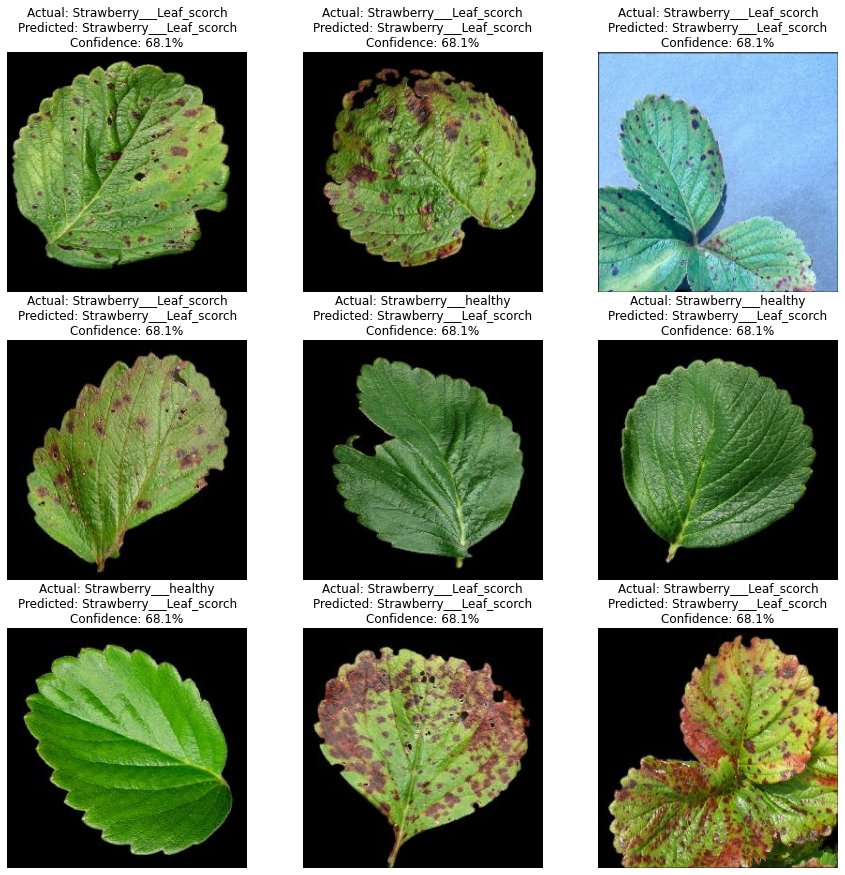

Training model with activations: ['selu', 'tanh', 'sigmoid', 'relu', 'selu', 'tanh', 'sigmoid']
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 586ms/step - accuracy: 0.7175 - loss: 0.6489 - val_accuracy: 0.7422 - val_loss: 0.5963
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 588ms/step - accuracy: 0.7205 - loss: 0.5838 - val_accuracy: 0.8594 - val_loss: 0.3126
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step - accuracy: 0.8790 - loss: 0.2825 - val_accuracy: 1.0000 - val_loss: 0.0423
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 608ms/step - accuracy: 0.9865 - loss: 0.0603 - val_accuracy: 0.9609 - val_loss: 0.0891
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 597ms/step - accuracy: 0.9763 - loss: 0.0610 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 573ms/step - accuracy: 0.9964 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 577ms/step - accuracy: 0.9992 - loss: 0.0108 - val_accuracy: 0.9766 - val_loss: 0.0466
E

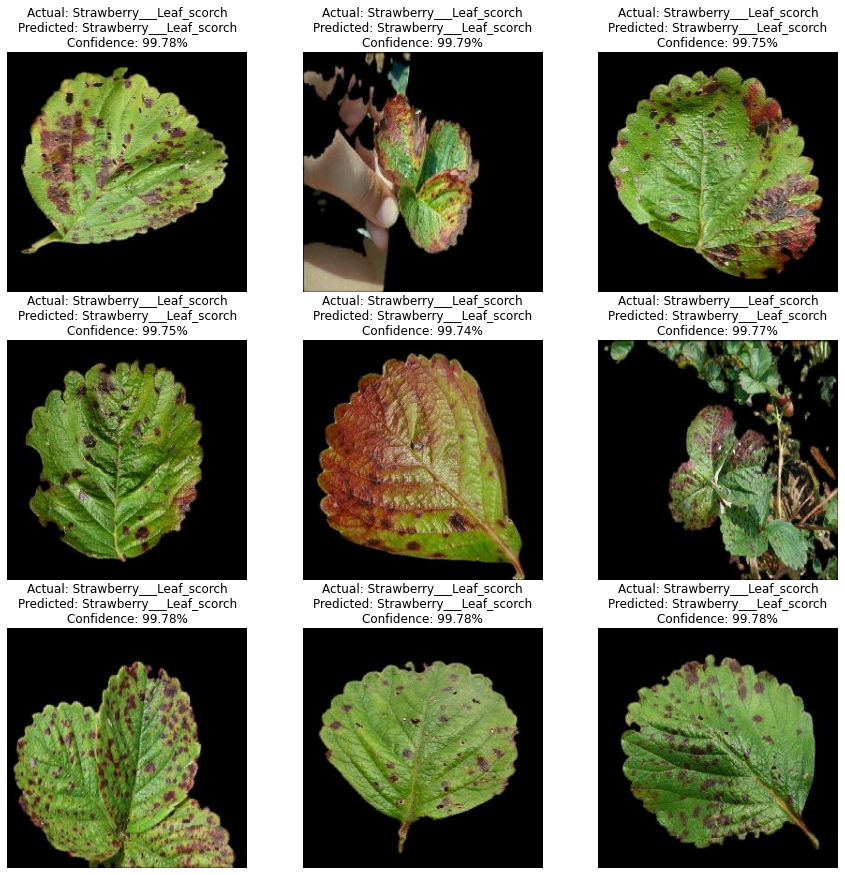

Results saved to activation_function_results.csv


In [6]:
activation_functions_sets = [
    ['relu', 'sigmoid', 'tanh', 'relu', 'sigmoid', 'tanh', 'relu'],
    ['tanh', 'relu', 'selu', 'sigmoid', 'tanh', 'relu', 'selu'],
    ['sigmoid', 'selu', 'relu', 'tanh', 'sigmoid', 'selu', 'tanh'],
    ['selu', 'tanh', 'sigmoid', 'relu', 'selu', 'tanh', 'sigmoid']
]

results_df = pd.DataFrame(columns=['Activation Functions', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'Loss'])
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

for activations in activation_functions_sets:
    print(f"Training model with activations: {activations}")
    model = create_model(input_shape, n_classes, activations)
    model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)
    precision, recall, f1, accuracy, loss = predict_and_evaluate(model, test_ds)
    results_df = results_df.append({'Activation Functions': activations, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Accuracy': accuracy, 'Loss': loss}, ignore_index=True)

results_df.to_csv('activation_function_results.csv', index=False)
print("Results saved to activation_function_results.csv")


# Displaying the Results in Matrix Form and Identifying the Best Architecture for Each Metric

Formatted Results:
                     Precision    Recall  F1 Score  Accuracy      Loss
First Architecture    0.937863  0.932292  0.928311  0.932292  0.153615
Second Architecture   0.994827  0.994792  0.994773  0.994792  0.008651
Third Architecture    0.570340  0.755208  0.649883  0.755208  0.569872
Fourth Architecture   0.994827  0.994792  0.994773  0.994792  0.012410


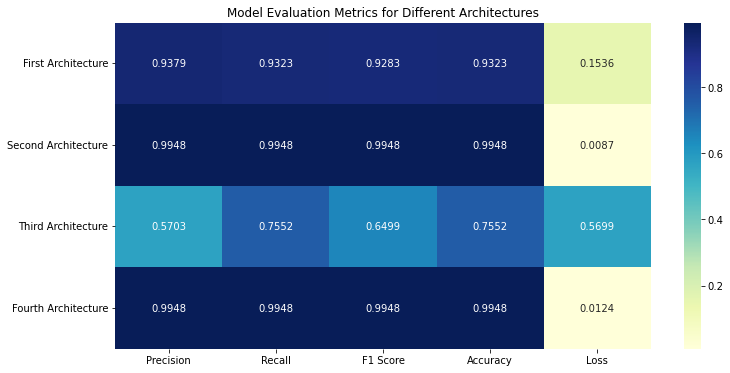

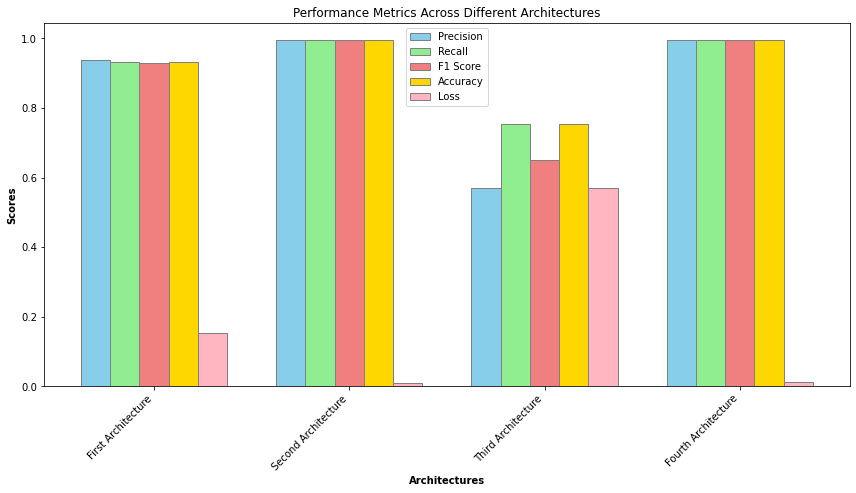

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from CSV
results_df = pd.read_csv('activation_function_results.csv')

# Define custom row names
row_names = ['First Architecture', 'Second Architecture', 'Third Architecture', 'Fourth Architecture']

# Create a new DataFrame with custom row and column names
formatted_results_df = pd.DataFrame(
    results_df[['Precision', 'Recall', 'F1 Score', 'Accuracy', 'Loss']].values,
    index=row_names,
    columns=['Precision', 'Recall', 'F1 Score', 'Accuracy', 'Loss']
)

# Display the DataFrame
print("Formatted Results:")
print(formatted_results_df)

# Display the DataFrame using a heatmap for a visually appealing output
plt.figure(figsize=(12, 6))
sns.heatmap(formatted_results_df, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Model Evaluation Metrics for Different Architectures')
plt.show()

# Define the metric scores for each architecture
precision_scores = formatted_results_df['Precision']
recall_scores = formatted_results_df['Recall']
f1_scores = formatted_results_df['F1 Score']
accuracy_scores = formatted_results_df['Accuracy']
loss_scores = formatted_results_df['Loss']

# Define the architectures
architectures = row_names

# Set the width of the bars
barWidth = 0.15

# Set the position of the bars on the x-axis
r1 = np.arange(len(precision_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Plotting the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, precision_scores, color='skyblue', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recall_scores, color='lightgreen', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_scores, color='lightcoral', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r4, accuracy_scores, color='gold', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r5, loss_scores, color='lightpink', width=barWidth, edgecolor='grey', label='Loss')

# Adding xticks and labels
plt.xlabel('Architectures', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + barWidth*2 for r in range(len(precision_scores))], architectures)
plt.title('Performance Metrics Across Different Architectures')
plt.legend()

# Show plot
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()


# Saving the Model

In [8]:
import os
import tensorflow as tf

# Define the directory path
directory_path = r'C:\Users\RITUJA\strawberry disease\training'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save the model
model_path = os.path.join(directory_path, 'my_model.keras')
tf.keras.models.save_model(model, model_path)

print("Model saved at:", model_path)


Model saved at: C:\Users\RITUJA\strawberry disease\training\my_model.keras
